In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json

from gcpUtils.auth import getCredentials
from gcpUtils.bigQuery import pandasToBq, tableToPandas
from gcpUtils.google_storage_manager import *

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

In [90]:
with open("dados/filiais_inferior_30.json", 'r', encoding='utf-8') as f:
    dados_filiais = json.load(f)

lista_de_filiais = [item['FILIAL'] for item in dados_filiais]
filiais_corretas = ", ".join([f"'{f}'" for f in lista_de_filiais])


In [91]:
cred = getCredentials("../bd/planejamento-animale-292719-296d49ccdea6.json")

query = f"""
WITH rupturas AS (
    SELECT
        FILIAL,
        SKU,
        DATA,
        CONT_RUPTURA,
        LEADTIME,
        CASE 
            WHEN CONT_RUPTURA = 1
                AND LAG(CONT_RUPTURA, 1, 0) OVER (
                    PARTITION BY FILIAL, SKU ORDER BY DATA
                ) = 0
            THEN 1 ELSE 0
        END AS inicio_ruptura
    FROM `planejamento-animale-292719.checklists_rollout.ANIMALE_checklist`
    WHERE DATA > '2024-09-01' 
      AND DATA < '2025-09-01'
      AND FILIAL IN ({filiais_corretas})
),
grupos AS (
    SELECT
        FILIAL,
        SKU,
        DATA,
        CONT_RUPTURA,
        LEADTIME,
        SUM(inicio_ruptura) OVER (
            PARTITION BY FILIAL, SKU ORDER BY DATA ROWS UNBOUNDED PRECEDING
        ) AS RUPTURA_ID
    FROM rupturas
    WHERE CONT_RUPTURA = 1
),
resumo AS (
    SELECT
        FILIAL,
        SKU,
        RUPTURA_ID,
        MIN(CAST(DATA AS DATE)) AS inicio_ruptura,
        MAX(CAST(DATA AS DATE)) AS fim_ruptura,
        DATE_DIFF(
        MAX(CAST(DATA AS DATE)), MIN(CAST(DATA AS DATE)), DAY
        ) + 1 AS DIAS_RUPTURA,
        MAX(LEADTIME) AS LEADTIME
    FROM grupos
    GROUP BY FILIAL, SKU, RUPTURA_ID
)
SELECT *
FROM resumo
ORDER BY FILIAL, SKU, RUPTURA_ID;
"""


In [92]:
dados = tableToPandas(query, 'planejamento-animale-292719', cred)
dados.columns = dados.columns.str.upper()

In [100]:
# calculando IET e classificação
epsilon = 1e-9
alpha = 0.3
dados['IET'] = (dados['LEADTIME'] - dados['DIAS_RUPTURA']) / \
               (dados['DIAS_RUPTURA'] + epsilon)

conditions = [
    dados['IET'] < -1 * alpha,  # Ruim: IET menor que -alpha
    dados['IET'] > alpha,]   # Bom: IET maior que alpha]




choices = ['Ruim', 'Bom']
dados['CLASSE'] = np.select(conditions, choices, default='Razoável')

# Agrupar por filial e calcular o IET médio e o número de rupturas
desempenho_filiais = dados.groupby('FILIAL')['IET'].agg(['mean', 'count']).reset_index()
desempenho_filiais.rename(columns={'mean': 'IET_MEDIO', 'count': 'QTD_RUPTURAS'}, inplace=True)

# Ordenar as filiais pelo IET médio para criar um ranking
desempenho_filiais = desempenho_filiais.sort_values('IET_MEDIO', ascending=False)

print("Tabela de Desempenho por Filial:")
print(desempenho_filiais.head())



Tabela de Desempenho por Filial:
                       FILIAL  IET_MEDIO  QTD_RUPTURAS
37           ANIMALE NATAL CM   1.986013          6040
12  ANIMALE ESTACAO CUIABA CM   1.854546          8306
43          ANIMALE RECIFE CM    1.84538          8130
46   ANIMALE RIOMAR FORTAL CM   1.836215         11360
52   ANIMALE SHOP BRASILIA CM   1.834614          8978


In [97]:
# Contagem de lojas por classe
contagem_classe = dados['CLASSE'].value_counts()

lojas_media_ruptura = dados.groupby('FILIAL').agg(
    DIAS_RUPTURA_MEDIA=('DIAS_RUPTURA', 'mean')
).reset_index()

lojas_media_ruptura

,FILIAL,DIAS_RUPTURA_MEDIA
0,ANIMALE ALPHAVILLE CM,24.22351
1,ANIMALE ARACAJU CM,18.671373
2,ANIMALE BALNEARIO SHOP CM,20.481594
3,ANIMALE BARIGUI CM,18.795844
4,ANIMALE BARRA SALVADOR CM,18.002042
...,...,...
57,ANIMALE VILA NOVA CM,18.883502
58,ANIMALE VILA VELHA CM,18.994278
59,ANIMALE VILLA LOBOS CM,21.180812
60,ANIMALE VILLAGE MALL CM,20.816552


C:\Users\gabri\AppData\Local\Temp\ipykernel_49948\1976388884.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


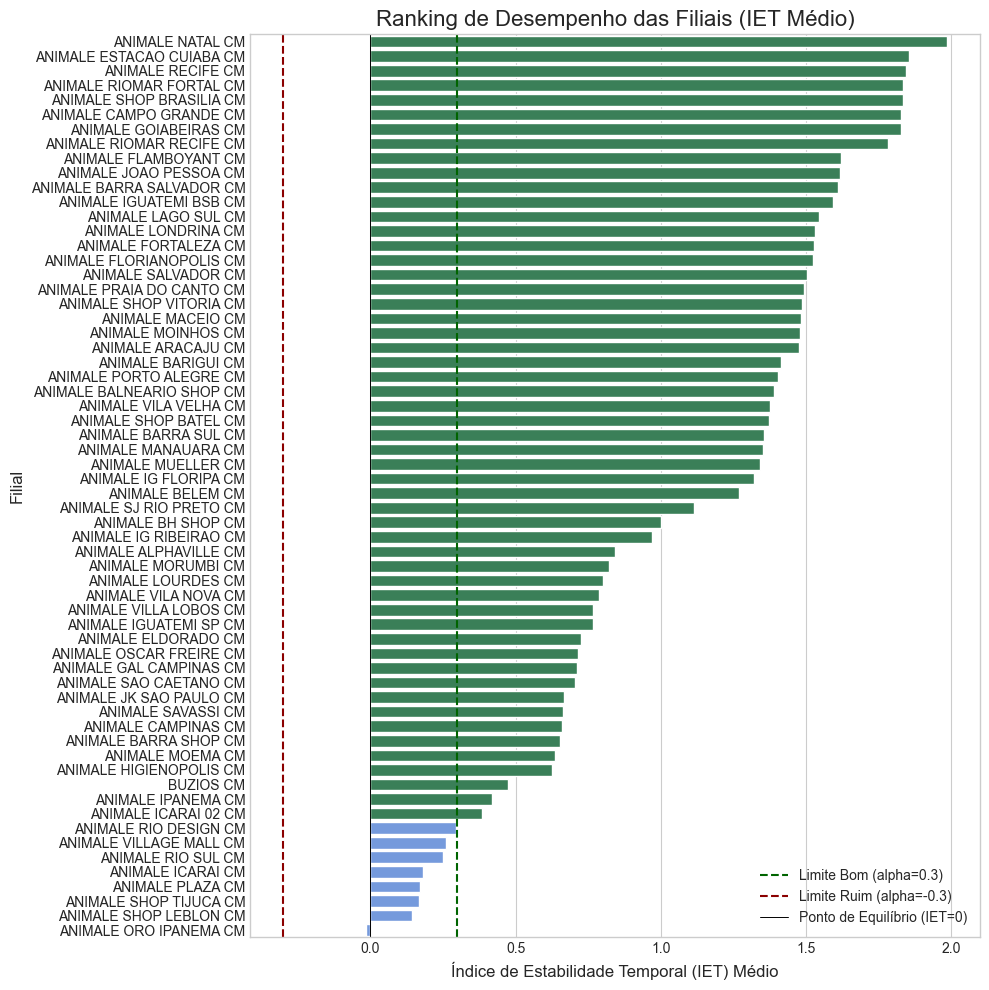

In [94]:
# Criar uma paleta de cores para destacar Bom, Razoável e Ruim
cores = []
for iet in desempenho_filiais['IET_MEDIO']:
    if iet > alpha:
        cores.append('seagreen')  # Cor para 'Bom'
    elif iet < -alpha:
        cores.append('indianred') # Cor para 'Ruim'
    else:
        cores.append('cornflowerblue') # Cor para 'Razoável'

# Criar a figura e os eixos
plt.figure(figsize=(10, 10)) # Ajuste o tamanho conforme o número de filiais

# Criar o gráfico de barras
barplot = sns.barplot(
    x='IET_MEDIO',
    y='FILIAL',
    data=desempenho_filiais,
    palette=cores,
    orient='h'
)

# Adicionar linhas de referência para os limites de 'alpha'
plt.axvline(x=alpha, color='darkgreen', linestyle='--', label=f'Limite Bom (alpha={alpha})')
plt.axvline(x=-alpha, color='darkred', linestyle='--', label=f'Limite Ruim (alpha={-alpha})')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.7, label='Ponto de Equilíbrio (IET=0)')


# Melhorar o layout
plt.title('Ranking de Desempenho das Filiais (IET Médio)', fontsize=16)
plt.xlabel('Índice de Estabilidade Temporal (IET) Médio', fontsize=12)
plt.ylabel('Filial', fontsize=12)
plt.legend()
plt.tight_layout()

plt.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_49948\714949774.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


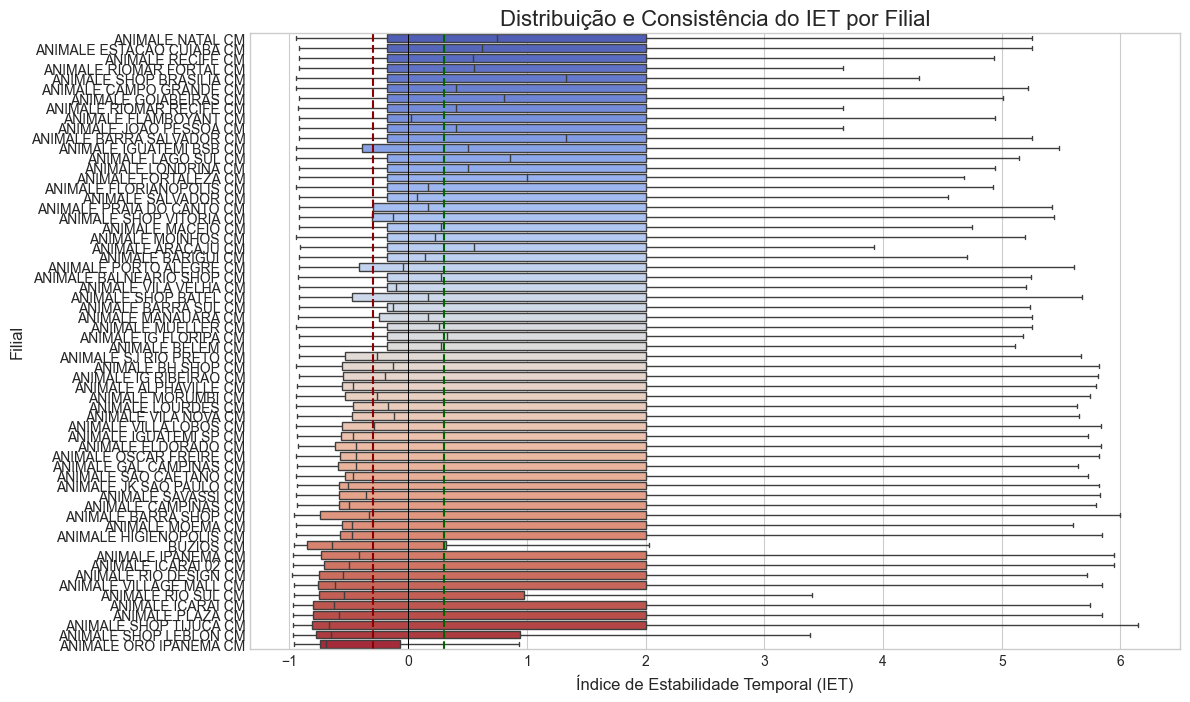

In [96]:
# Para o Box Plot, precisamos ordenar o eixo y para que fique igual ao ranking
ordem_filiais = desempenho_filiais['FILIAL'].tolist()

plt.figure(figsize=(12, 8))

sns.boxplot(
    x='IET',
    y='FILIAL',
    data=dados,
    order=ordem_filiais,
    palette='coolwarm',
    showfliers=False # Oculta outliers para um visual mais limpo
)

plt.axvline(x=alpha, color='darkgreen', linestyle='--')
plt.axvline(x=-alpha, color='darkred', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.7)

plt.title('Distribuição e Consistência do IET por Filial', fontsize=16)
plt.xlabel('Índice de Estabilidade Temporal (IET)', fontsize=12)
plt.ylabel('Filial', fontsize=12)
plt.show()


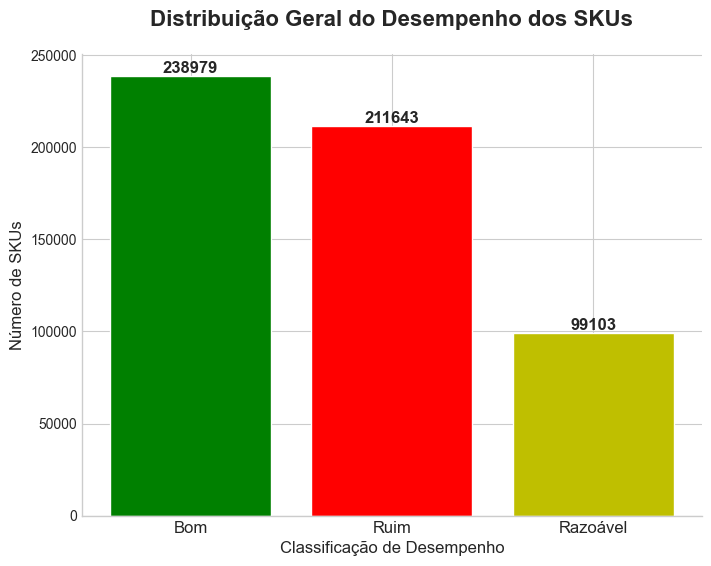

In [98]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    contagem_classe.index, 
    contagem_classe.values, 
    color=('g','r','y')
)

ax.bar_label(bars, fontsize=12, fontweight='bold')

ax.set_title('Distribuição Geral do Desempenho dos SKUs', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Número de SKUs', fontsize=12)
ax.set_xlabel('Classificação de Desempenho', fontsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.spines[['top', 'right']].set_visible(False)
plt.show()

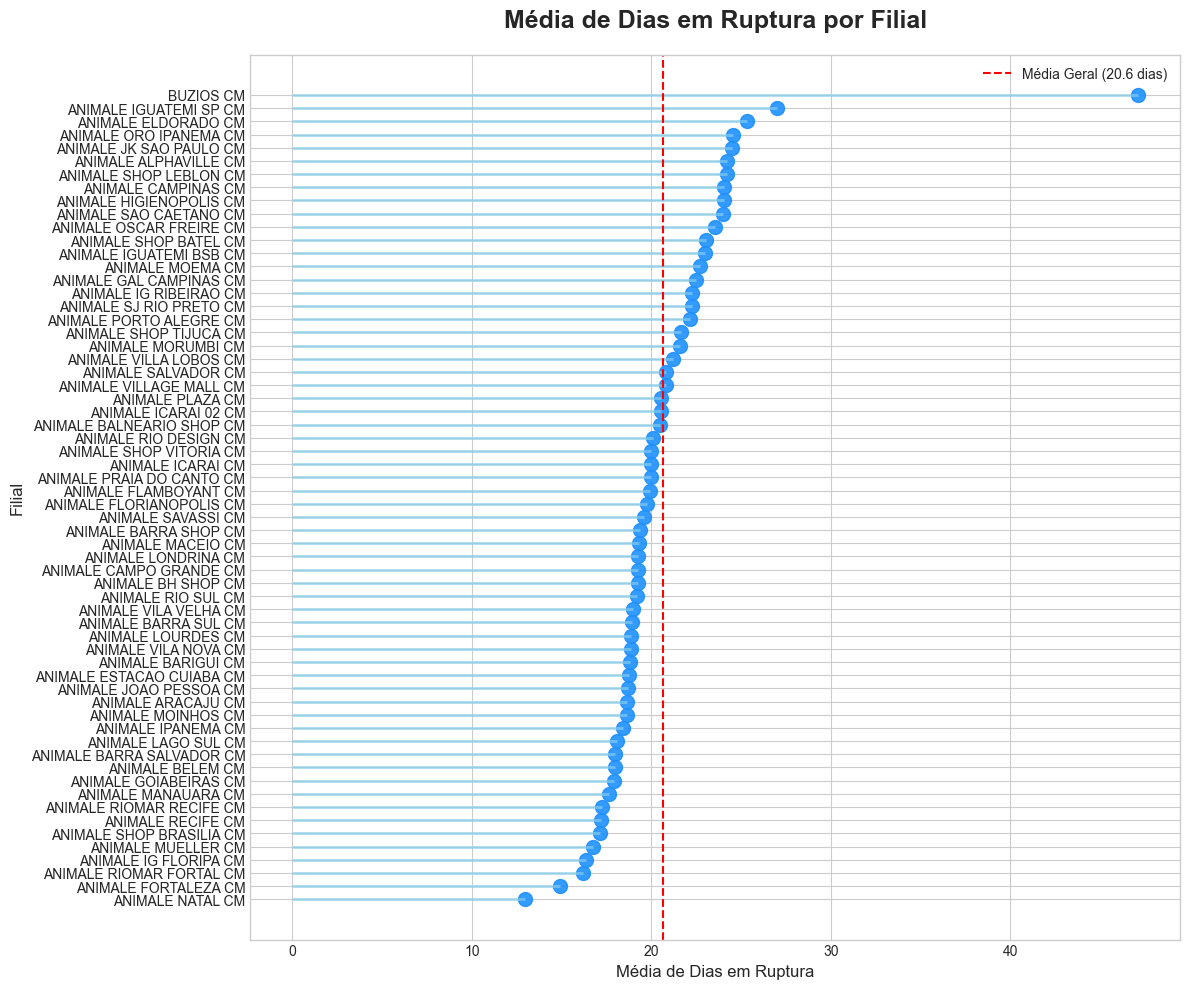

In [99]:
# Seus dados já estão prontos em 'lojas_media_ruptura'

# Ordenando os dados para a visualização
lojas_media_ruptura_sorted = lojas_media_ruptura.sort_values('DIAS_RUPTURA_MEDIA', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Criando as "hastes" e os "pontos"
ax.hlines(y=lojas_media_ruptura_sorted['FILIAL'], xmin=0, xmax=lojas_media_ruptura_sorted['DIAS_RUPTURA_MEDIA'], color='skyblue', alpha=0.7, linewidth=2)
ax.scatter(x=lojas_media_ruptura_sorted['DIAS_RUPTURA_MEDIA'], y=lojas_media_ruptura_sorted['FILIAL'], s=100, color='dodgerblue', alpha=0.9)

# Linha da média geral para contexto
media_geral = lojas_media_ruptura_sorted['DIAS_RUPTURA_MEDIA'].mean()
ax.axvline(x=media_geral, color='red', linestyle='--', linewidth=1.5, label=f'Média Geral ({media_geral:.1f} dias)')
ax.legend()

# Títulos e labels
ax.set_title('Média de Dias em Ruptura por Filial', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Média de Dias em Ruptura', fontsize=12)
ax.set_ylabel('Filial', fontsize=12)

plt.tight_layout()
plt.show()